## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [133]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def store_image(img, img_dir, fname):
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    img_path = img_dir + fname.split('/')[-1]
    #print(img_path)
    cv2.imwrite(img_path, img)
        
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #store every images with detected corners for post analyse and writeup
            img_dir = 'output_images/chessboard_corners/'
            img_path = img_dir + fname.split('/')[-1]
            store_image(img, img_dir, img_path)
    #calibrate camera with identified objpoints and imgpoints
    img_size = (img.shape[1], img.shape[0])
    return cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img_copy = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HLS).astype(np.float)
    #hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    #l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #hsv[:,:,1]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def warp(img,tobird=True):
    corners = np.float32([[190,720],[590,460],[700,460],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255,0,0))    

# Calibrate camera

In [105]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

## Test pipeline on test images and store output

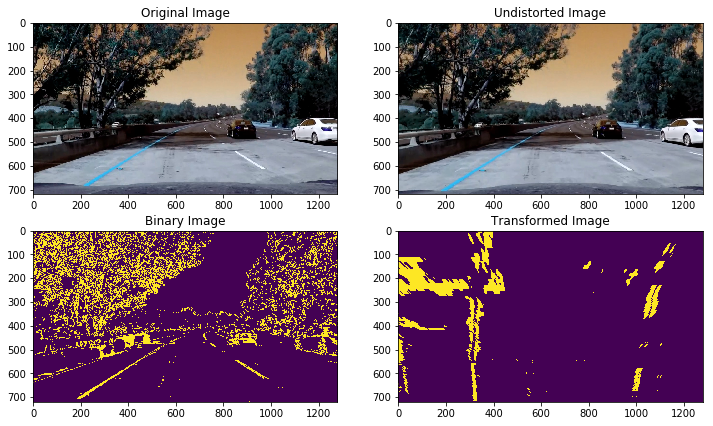

In [115]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

def preprocess_img(img):
    undist_img = undistort(img)
    binary_image = pipeline(undist_img)
    transformed = warp(binary_image)
    region_sel  = region_of_interest(transformed)
    return region_sel

# process test images
for fname in images:
    img = cv2.imread(fname)
    undist_img = undistort(img)
    #draw_lines(undist_img, src)
    store_image(undist_img, 'output_images/undistorted/', fname)
    binary_image = pipeline(undist_img)
    store_image(binary_image*255, 'output_images/binary_images/', fname)
    #transformed = transform(undist_img, src, dst)
    transformed = warp(binary_image)
    region_sel  = region_of_interest(transformed)
    store_image(region_sel*255, 'output_images/transformed_images/', fname)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undist_img)
plt.title("Undistorted Image")
#img = cv2.imread('test_images/test1.jpg')
plt.subplot(2, 2, 3)
plt.imshow(binary_image*255)
plt.title("Binary Image")
plt.subplot(2, 2, 4)
plt.imshow(transformed*255)
plt.title("Transformed Image")

In [129]:
def slide_and_fitpoly(binary_warped, fname=None):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #plot
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if(fname!=None):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig(fname)
    
    return left_fitx, right_fitx, ploty

#next frame fit poly
def fitpoly_next(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit


In [130]:
# Generate x and y values for plotting
def plot_poly(undist, warped, left_fitx, right_fitx, ploty, fname=None):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, False) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    if fname!=None:
        plt.savefig(fname)
    
    return result

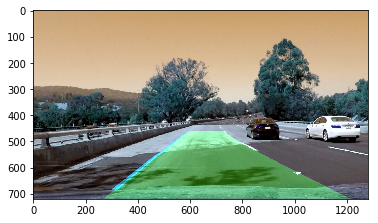

In [144]:
# process test images
#for fname in images:
img = cv2.imread('test_images/test4.jpg')
prep_img = preprocess_img(img)
left_fitx,right_fitx, ploty = slide_and_fitpoly(prep_img)
result = plot_poly(img, prep_img, left_fitx,  right_fitx, ploty)
plt.imshow(result)
plt.savefig('output_images/test4_final_lane.jpg')       


In [135]:
def process_image(img):
    prep_img = preprocess_img(img)
    left_fitx,right_fitx, ploty = slide_and_fitpoly(prep_img)
    result = plot_poly(img, prep_img, left_fitx,  right_fitx, ploty)
    return result

In [136]:
out_dir='./'
output = out_dir+'processed_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████▉| 1260/1261 [03:13<00:00,  6.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

CPU times: user 7min 3s, sys: 21.1 s, total: 7min 25s
Wall time: 3min 15s
